# Procesamiento de Datos de Pólizas de Cumplimiento

**Objetivo:** Procesar las tablas de producción y siniestros de cumplimiento según los criterios actuariales definidos.

## Criterios de Procesamiento:

### Producción (ProdCumpli.csv):
- Eliminar variables: conta, anio, Mes
- Eliminar registros con ValorPrimaEquiv = 0
- Calcular tiempo de cobertura en años
- Clasificar cobertura en categorías

### Siniestros (SiniesCumpli.csv):
- Eliminar variables: Conta, anio, Mes, SINIESTRO, ULT_FECHA_PAGO, PAGOS
- Eliminar registros con RESERVA_ACTUAL_EQUI = 0

In [178]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


## 1. Carga de Datos

In [179]:
# Rutas de archivos
path_in = '../data/in/'
path_out = '../data/out/'

# Cargar datos
print("Cargando datos...")
df_prod = pd.read_csv(path_in + 'ProdCumpli.csv')
df_sin = pd.read_csv(path_in + 'SiniesCumpli.csv')

print(f"\nProducción - Registros originales: {len(df_prod):,}")
print(f"Siniestros - Registros originales: {len(df_sin):,}")

Cargando datos...

Producción - Registros originales: 1,242,477
Siniestros - Registros originales: 202,984


In [180]:
# Vista previa de datos originales
print("\n=== PRODUCCIÓN - Vista Previa ===")
print(df_prod.head())
print(f"\nColumnas: {list(df_prod.columns)}")
print(f"\nShape: {df_prod.shape}")


=== PRODUCCIÓN - Vista Previa ===
   conta  anio  Mes     Poliza  CodSucursal          Ramo  \
0      1  2025    6      62512            9  CUMPLIMIENTO   
1      2  2025    6     614751           43  CUMPLIMIENTO   
2      3  2025    6    1001850           12  CUMPLIMIENTO   
3      4  2025    6    1002709           12  CUMPLIMIENTO   
4      5  2025    6  100038036           10  CUMPLIMIENTO   

  VigenciaInicioPoliza VigenciaFinPoliza  ValorPrimaEquiv  \
0           09/07/2003        09/10/2030         11544.00   
1           10/06/2000        18/07/2078         80000.00   
2           05/12/2008        09/02/2029         22000.00   
3           10/07/2009        10/02/2029         22000.00   
4           29/09/2014        29/09/2025        204446.81   

                              Amparo  
0             ESTABILIDAD DE LA OBRA  
1              SERIEDAD DE LA OFERTA  
2                       CUMPLIMIENTO  
3                       CUMPLIMIENTO  
4  CALIDAD Y CORRECTO FUNCIONAMIENTO

In [181]:
print("\n=== SINIESTROS - Vista Previa ===")
print(df_sin.head())
print(f"\nColumnas: {list(df_sin.columns)}")
print(f"\nShape: {df_sin.shape}")


=== SINIESTROS - Vista Previa ===
   Conta  anio  Mes  cod_suc  SINIESTRO  POLIZA DEPARTAMENTO_SINIESTRO  \
0      1  2015    1       11      50243  645675         11-BOGOTA D.C.   
1      2  2015    1       11      50132  645675         11-BOGOTA D.C.   
2      3  2015    1       11      50134  645675         11-BOGOTA D.C.   
3      4  2015    1       11      50151  645675         11-BOGOTA D.C.   
4      5  2015    1       10    1000173  613108            5-ANTIOQUIA   

   VALOR_ASEGURADO FECHA_DE_SINIESTRO FECHA_AVISO                  AMPARO  \
0     1.314751e+09         23/08/2005  26/08/2005   DISPOSICIONES LEGALES   
1     1.314751e+09         23/05/2005  01/06/2005   DISPOSICIONES LEGALES   
2     1.314751e+09         24/05/2005  01/06/2005   DISPOSICIONES LEGALES   
3     1.314751e+09         15/06/2005  21/06/2005   DISPOSICIONES LEGALES   
4     2.415316e+09         21/05/2009  26/05/2009  ESTABILIDAD DE LA OBRA   

  ULT_FECHA_PAGO  PAGOS  RESERVA_ACTUAL_EQUI          RAM

### Filtrar Última Consulta (Snapshot más reciente)

Las variables `anio` y `mes` indican la fecha de consulta de la base de datos. Filtraremos para quedarnos solo con la última consulta.

In [ ]:
# Filtrar última consulta en PRODUCCIÓN
print("=== FILTRO DE ÚLTIMA CONSULTA - PRODUCCIÓN ===\n")

# Identificar última consulta
max_anio_prod = df_prod['anio'].max()
df_prod_max_anio = df_prod[df_prod['anio'] == max_anio_prod]
max_mes_prod = df_prod_max_anio['Mes'].max()

print(f"Última consulta identificada:")
print(f"  Año: {max_anio_prod}")
print(f"  Mes: {max_mes_prod}")

# Filtrar solo última consulta
registros_antes = len(df_prod)
df_prod = df_prod[(df_prod['anio'] == max_anio_prod) & (df_prod['Mes'] == max_mes_prod)].copy()
registros_despues = len(df_prod)

print(f"\nRegistros:")
print(f"  Antes del filtro: {registros_antes:,}")
print(f"  Después del filtro: {registros_despues:,}")
print(f"  Eliminados: {registros_antes - registros_despues:,} ({(registros_antes - registros_despues)/registros_antes*100:.2f}%)")
print(f"\n✓ Producción filtrada a última consulta")

In [182]:
# Filtrar última consulta en SINIESTROS
print("\n=== FILTRO DE ÚLTIMA CONSULTA - SINIESTROS ===\n")

# Identificar última consulta
max_anio_sin = df_sin['anio'].max()
df_sin_max_anio = df_sin[df_sin['anio'] == max_anio_sin]
max_mes_sin = df_sin_max_anio['Mes'].max()

print(f"Última consulta identificada:")
print(f"  Año: {max_anio_sin}")
print(f"  Mes: {max_mes_sin}")

# Filtrar solo última consulta
registros_antes = len(df_sin)
df_sin = df_sin[(df_sin['anio'] == max_anio_sin) & (df_sin['Mes'] == max_mes_sin)].copy()
registros_despues = len(df_sin)

print(f"\nRegistros:")
print(f"  Antes del filtro: {registros_antes:,}")
print(f"  Después del filtro: {registros_despues:,}")
print(f"  Eliminados: {registros_antes - registros_despues:,} ({(registros_antes - registros_despues)/registros_antes*100:.2f}%)")
print(f"\n✓ Siniestros filtrados a última consulta")

print("\n" + "="*70)
print("RESUMEN - FILTRO DE ÚLTIMA CONSULTA")
print("="*70)
print(f"\nProducción: {max_anio_prod}-{max_mes_prod:02d} | {registros_despues:,} registros")
print(f"Siniestros: {max_anio_sin}-{max_mes_sin:02d} | {len(df_sin):,} registros")
print("\n✓ Ambas tablas filtradas a su snapshot más reciente")


=== FILTRO DE ÚLTIMA CONSULTA - SINIESTROS ===

Última consulta identificada:
  Año: 2025
  Mes: 6

Registros:
  Antes del filtro: 202,984
  Después del filtro: 4,459
  Eliminados: 198,525 (97.80%)

✓ Siniestros filtrados a última consulta

RESUMEN - FILTRO DE ÚLTIMA CONSULTA


NameError: name 'max_anio_prod' is not defined

## 2. Procesamiento de Tabla de Producción

In [ ]:
# Copia para procesamiento
df_prod_proc = df_prod.copy()

print("=== PROCESAMIENTO PRODUCCIÓN ===")
print(f"\nRegistros iniciales: {len(df_prod_proc):,}")

=== PROCESAMIENTO PRODUCCIÓN ===

Registros iniciales: 1,242,477


In [ ]:
# 1. Eliminar registros con ValorPrimaEquiv = 0
registros_antes = len(df_prod_proc)
df_prod_proc = df_prod_proc[df_prod_proc['ValorPrimaEquiv'] != 0]
registros_eliminados = registros_antes - len(df_prod_proc)

print(f"\nRegistros con ValorPrimaEquiv = 0 eliminados: {registros_eliminados:,}")
print(f"Registros restantes: {len(df_prod_proc):,}")


Registros con ValorPrimaEquiv = 0 eliminados: 83,342
Registros restantes: 1,159,135


In [ ]:
# 2. Convertir fechas a formato datetime
print("\nConvirtiendo fechas...")
df_prod_proc['VigenciaInicioPoliza'] = pd.to_datetime(df_prod_proc['VigenciaInicioPoliza'], format='%d/%m/%Y', errors='coerce')
df_prod_proc['VigenciaFinPoliza'] = pd.to_datetime(df_prod_proc['VigenciaFinPoliza'], format='%d/%m/%Y', errors='coerce')

# Verificar conversión
print(f"Fechas nulas en VigenciaInicioPoliza: {df_prod_proc['VigenciaInicioPoliza'].isna().sum()}")
print(f"Fechas nulas en VigenciaFinPoliza: {df_prod_proc['VigenciaFinPoliza'].isna().sum()}")


Convirtiendo fechas...
Fechas nulas en VigenciaInicioPoliza: 0
Fechas nulas en VigenciaFinPoliza: 0


In [ ]:
# 3. Calcular tiempo de cobertura en años
print("\nCalculando tiempo de cobertura...")
df_prod_proc['TiempoCobertura_dias'] = (df_prod_proc['VigenciaFinPoliza'] - df_prod_proc['VigenciaInicioPoliza']).dt.days
df_prod_proc['TiempoCobertura_anios'] = df_prod_proc['TiempoCobertura_dias'] / 365.25

print("\nEstadísticas de Tiempo de Cobertura (años):")
print(df_prod_proc['TiempoCobertura_anios'].describe())


Calculando tiempo de cobertura...

Estadísticas de Tiempo de Cobertura (años):
count    1.159135e+06
mean     2.552742e+00
std      1.769479e+00
min      0.000000e+00
25%      6.789870e-01
50%      3.085558e+00
75%      3.586585e+00
max      7.810267e+01
Name: TiempoCobertura_anios, dtype: float64


### Análisis de Temporalidad por Amparo

Antes de clasificar el tiempo de cobertura, analizamos la distribución para los principales amparos.

In [ ]:
# Identificar top 3 amparos
print("Top 3 Amparos en Producción:")
top_3_amparos = df_prod_proc['Amparo'].value_counts().head(3)
print(top_3_amparos)
print(f"\nRepresentan {(top_3_amparos.sum() / len(df_prod_proc) * 100):.2f}% del total")

# Estadísticas de tiempo de cobertura por amparo
print("\n" + "="*70)
print("ESTADÍSTICAS DE TIEMPO DE COBERTURA POR AMPARO (años)")
print("="*70)

for amparo in top_3_amparos.index:
    datos_amparo = df_prod_proc[df_prod_proc['Amparo'] == amparo]['TiempoCobertura_anios']
    print(f"\n{amparo}:")
    print(f"  Registros: {len(datos_amparo):,}")
    print(f"  Media: {datos_amparo.mean():.2f} años")
    print(f"  Mediana: {datos_amparo.median():.2f} años")
    print(f"  P25: {datos_amparo.quantile(0.25):.2f} años")
    print(f"  P75: {datos_amparo.quantile(0.75):.2f} años")
    print(f"  Min: {datos_amparo.min():.2f} años")
    print(f"  Max: {datos_amparo.max():.2f} años")

Top 3 Amparos en Producción:
Amparo
PRESTACIONES SOCIALES    487414
CUMPLIMIENTO             205069
CALIDAD DEL SERVICIO     166672
Name: count, dtype: int64

Representan 74.12% del total

ESTADÍSTICAS DE TIEMPO DE COBERTURA POR AMPARO (años)

PRESTACIONES SOCIALES:
  Registros: 487,414
  Media: 2.82 años
  Mediana: 3.16 años
  P25: 1.97 años
  P75: 3.64 años
  Min: 0.00 años
  Max: 36.33 años

CUMPLIMIENTO:
  Registros: 205,069
  Media: 2.10 años
  Mediana: 1.32 años
  P25: 0.75 años
  P75: 3.40 años
  Min: 0.00 años
  Max: 20.18 años

CALIDAD DEL SERVICIO:
  Registros: 166,672
  Media: 2.37 años
  Mediana: 2.68 años
  P25: 0.65 años
  P75: 3.58 años
  Min: 0.00 años
  Max: 19.03 años


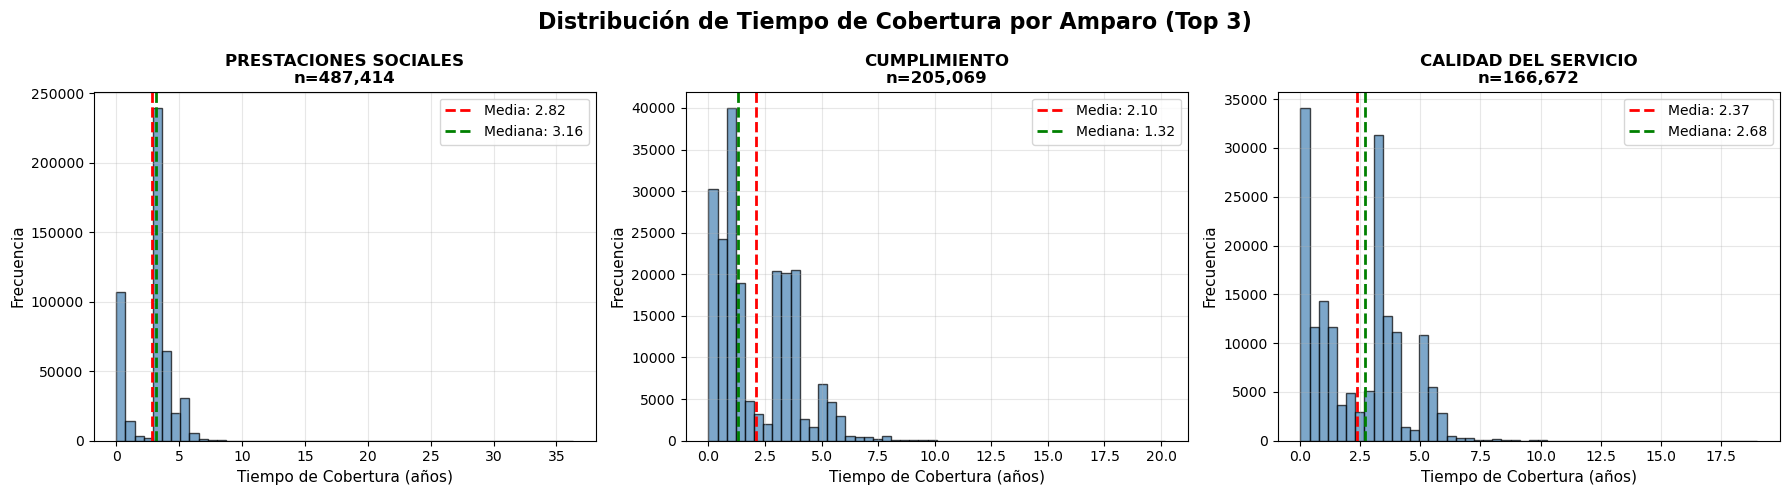


📌 Usar estos histogramas para definir rangos de clasificación de temporalidad apropiados.


In [ ]:
# Histogramas de tiempo de cobertura para top 3 amparos
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribución de Tiempo de Cobertura por Amparo (Top 3)', fontsize=16, fontweight='bold')

for idx, amparo in enumerate(top_3_amparos.index):
    datos_amparo = df_prod_proc[df_prod_proc['Amparo'] == amparo]['TiempoCobertura_anios']
    
    axes[idx].hist(datos_amparo, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].axvline(datos_amparo.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {datos_amparo.mean():.2f}')
    axes[idx].axvline(datos_amparo.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {datos_amparo.median():.2f}')
    axes[idx].set_xlabel('Tiempo de Cobertura (años)', fontsize=11)
    axes[idx].set_ylabel('Frecuencia', fontsize=11)
    axes[idx].set_title(f'{amparo}\nn={len(datos_amparo):,}', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📌 Usar estos histogramas para definir rangos de clasificación de temporalidad apropiados.")

In [ ]:
# 4. Clasificar tiempo de cobertura
def clasificar_cobertura(anios):
    if pd.isna(anios):
        return 'Sin clasificar'
    elif anios < 0.5:
        return '0 a 0.5 años'
    elif anios < 1:
        return '0.5 a 1 año'
    elif anios < 2:
        return '1 a 2 años'
    elif anios < 3:
        return '2 a 3 años'
    elif anios < 4:
        return '3 a 4 años'
    else:
        return 'Más de 5 años'

df_prod_proc['CategoriaCobertura'] = df_prod_proc['TiempoCobertura_anios'].apply(clasificar_cobertura)

print("\nDistribución de Categorías de Cobertura:")
print(df_prod_proc['CategoriaCobertura'].value_counts().sort_index())
print(f"\nPorcentajes:")
print(df_prod_proc['CategoriaCobertura'].value_counts(normalize=True).sort_index() * 100)


Distribución de Categorías de Cobertura:
CategoriaCobertura
0 a 0.5 años     258615
0.5 a 1 año       80950
1 a 2 años        97379
2 a 3 años        30843
3 a 4 años       486648
Más de 5 años    204700
Name: count, dtype: int64

Porcentajes:
CategoriaCobertura
0 a 0.5 años     22.311034
0.5 a 1 año       6.983656
1 a 2 años        8.401006
2 a 3 años        2.660863
3 a 4 años       41.983721
Más de 5 años    17.659720
Name: proportion, dtype: float64


In [ ]:
# 5. Eliminar columnas especificadas
columnas_eliminar = ['conta', 'anio', 'Mes']
df_prod_proc = df_prod_proc.drop(columns=columnas_eliminar, errors='ignore')

print(f"\nColumnas eliminadas: {columnas_eliminar}")
print(f"Columnas finales: {list(df_prod_proc.columns)}")


Columnas eliminadas: ['conta', 'anio', 'Mes']
Columnas finales: ['Poliza', 'CodSucursal', 'Ramo', 'VigenciaInicioPoliza', 'VigenciaFinPoliza', 'ValorPrimaEquiv', 'Amparo', 'TiempoCobertura_dias', 'TiempoCobertura_anios', 'CategoriaCobertura']


## 3. Procesamiento de Tabla de Siniestros

In [ ]:
# Copia para procesamiento
df_sin_proc = df_sin.copy()

print("=== PROCESAMIENTO SINIESTROS ===")
print(f"\nRegistros iniciales: {len(df_sin_proc):,}")

=== PROCESAMIENTO SINIESTROS ===

Registros iniciales: 202,984


In [ ]:
# 1. Eliminar registros con RESERVA_ACTUAL_EQUI = 0
registros_antes = len(df_sin_proc)
df_sin_proc = df_sin_proc[df_sin_proc['RESERVA_ACTUAL_EQUI'] != 0]
registros_eliminados = registros_antes - len(df_sin_proc)

print(f"\nRegistros con RESERVA_ACTUAL_EQUI = 0 eliminados: {registros_eliminados:,}")
print(f"Registros restantes: {len(df_sin_proc):,}")


Registros con RESERVA_ACTUAL_EQUI = 0 eliminados: 4,884
Registros restantes: 198,100


In [ ]:
# 2. Eliminar columnas especificadas
columnas_eliminar = ['Conta', 'anio', 'Mes', 'SINIESTRO', 'ULT_FECHA_PAGO', 'PAGOS']
df_sin_proc = df_sin_proc.drop(columns=columnas_eliminar, errors='ignore')

print(f"\nColumnas eliminadas: {columnas_eliminar}")
print(f"Columnas finales: {list(df_sin_proc.columns)}")


Columnas eliminadas: ['Conta', 'anio', 'Mes', 'SINIESTRO', 'ULT_FECHA_PAGO', 'PAGOS']
Columnas finales: ['cod_suc', 'POLIZA', 'DEPARTAMENTO_SINIESTRO', 'VALOR_ASEGURADO', 'FECHA_DE_SINIESTRO', 'FECHA_AVISO', 'AMPARO', 'RESERVA_ACTUAL_EQUI', 'RAMO']


## 4. Resumen del Procesamiento

In [ ]:
print("\n" + "="*70)
print("RESUMEN DEL PROCESAMIENTO")
print("="*70)

print("\n--- PRODUCCIÓN ---")
print(f"Registros originales: {len(df_prod):,}")
print(f"Registros procesados: {len(df_prod_proc):,}")
print(f"Registros eliminados: {len(df_prod) - len(df_prod_proc):,} ({((len(df_prod) - len(df_prod_proc))/len(df_prod)*100):.2f}%)")
print(f"Columnas: {df_prod_proc.shape[1]}")

print("\n--- SINIESTROS ---")
print(f"Registros originales: {len(df_sin):,}")
print(f"Registros procesados: {len(df_sin_proc):,}")
print(f"Registros eliminados: {len(df_sin) - len(df_sin_proc):,} ({((len(df_sin) - len(df_sin_proc))/len(df_sin)*100):.2f}%)")
print(f"Columnas: {df_sin_proc.shape[1]}")


RESUMEN DEL PROCESAMIENTO

--- PRODUCCIÓN ---
Registros originales: 1,242,477
Registros procesados: 1,159,135
Registros eliminados: 83,342 (6.71%)
Columnas: 10

--- SINIESTROS ---
Registros originales: 202,984
Registros procesados: 198,100
Registros eliminados: 4,884 (2.41%)
Columnas: 9


In [ ]:
# Estadísticas descriptivas de Producción procesada
print("\n=== ESTADÍSTICAS PRODUCCIÓN PROCESADA ===")
print("\nPrimas:")
print(df_prod_proc['ValorPrimaEquiv'].describe())

print("\nAmparos más frecuentes:")
print(df_prod_proc['Amparo'].value_counts().head(10))


=== ESTADÍSTICAS PRODUCCIÓN PROCESADA ===

Primas:


count    1.159135e+06
mean     2.240488e+08
std      1.522622e+10
min      1.000000e-02
25%      4.456100e+04
50%      1.095110e+05
75%      4.495175e+05
max      7.043961e+12
Name: ValorPrimaEquiv, dtype: float64

Amparos más frecuentes:
Amparo
PRESTACIONES SOCIALES                487414
CUMPLIMIENTO                         205069
CALIDAD DEL SERVICIO                 166672
ESTABILIDAD DE LA OBRA               149367
CALIDAD DE LOS ELEMENTOS              42010
CALIDAD Y CORRECTO FUNCIONAMIENTO     30879
BUEN MANEJO DEL ANTICIPO              29963
SERIEDAD DE LA OFERTA                 19381
CALIDAD                               17600
PAGO ANTICIPADO                        4899
Name: count, dtype: int64


In [ ]:
# Estadísticas descriptivas de Siniestros procesados
print("\n=== ESTADÍSTICAS SINIESTROS PROCESADOS ===")
print("\nReservas:")
print(df_sin_proc['RESERVA_ACTUAL_EQUI'].describe())

print("\nAmparos más frecuentes:")
print(df_sin_proc['AMPARO'].value_counts().head(10))


=== ESTADÍSTICAS SINIESTROS PROCESADOS ===

Reservas:
count    1.981000e+05
mean     6.018226e+07
std      4.668419e+08
min      1.000000e-02
25%      1.796553e+06
50%      6.053107e+06
75%      1.500000e+07
max      3.465825e+10
Name: RESERVA_ACTUAL_EQUI, dtype: float64

Amparos más frecuentes:
AMPARO
CUMPLIMIENTO                      90096
PRESTACIONES SOCIALES             51075
DISPOSICIONES LEGALES             32335
BUEN MANEJO DEL ANTICIPO          13141
ESTABILIDAD DE LA OBRA             6883
SERIEDAD DE LA OFERTA              1307
CALIDAD DEL SERVICIO                955
CALIDAD                             736
CALIDAD DE LOS ELEMENTOS            609
CALIDAD Y CORRECTO FUNCIONAMIE      437
Name: count, dtype: int64


## 5. Guardar Datos Procesados

In [ ]:
# Guardar archivos procesados
print("\nGuardando archivos procesados...")

# Producción
output_file_prod = path_out + 'ProdCumpli_procesado.csv'
df_prod_proc.to_csv(output_file_prod, index=False)
print(f"✓ Producción guardada en: {output_file_prod}")

# Siniestros
output_file_sin = path_out + 'SiniesCumpli_procesado.csv'
df_sin_proc.to_csv(output_file_sin, index=False)
print(f"✓ Siniestros guardados en: {output_file_sin}")

print("\n¡Procesamiento completado exitosamente!")


Guardando archivos procesados...
✓ Producción guardada en: ../data/out/ProdCumpli_procesado.csv
✓ Siniestros guardados en: ../data/out/SiniesCumpli_procesado.csv

¡Procesamiento completado exitosamente!


In [ ]:
# Vista previa de datos procesados
print("\n=== VISTA PREVIA - PRODUCCIÓN PROCESADA ===")
df_prod_proc.head(10)


=== VISTA PREVIA - PRODUCCIÓN PROCESADA ===


,Poliza,CodSucursal,Ramo,VigenciaInicioPoliza,VigenciaFinPoliza,ValorPrimaEquiv,Amparo,TiempoCobertura_dias,TiempoCobertura_anios,CategoriaCobertura
0,62512,9,CUMPLIMIENTO,2003-07-09,2030-10-09,1.154400e+04,ESTABILIDAD DE LA OBRA,9954,27.252567,Más de 5 años
1,614751,43,CUMPLIMIENTO,2000-06-10,2078-07-18,8.000000e+04,SERIEDAD DE LA OFERTA,28527,78.102669,Más de 5 años
2,1001850,12,CUMPLIMIENTO,2008-12-05,2029-02-09,2.200000e+04,CUMPLIMIENTO,7371,20.180698,Más de 5 años
3,1002709,12,CUMPLIMIENTO,2009-07-10,2029-02-10,2.200000e+04,CUMPLIMIENTO,7155,19.589322,Más de 5 años
4,100038036,10,CUMPLIMIENTO,2014-09-29,2025-09-29,2.044468e+05,CALIDAD Y CORRECTO FUNCIONAMIENTO,4018,11.000684,Más de 5 años
5,100049134,10,CUMPLIMIENTO,2015-10-21,2025-10-21,1.118036e+09,CALIDAD DE LOS ELEMENTOS,3653,10.001369,Más de 5 años
6,100049134,10,CUMPLIMIENTO,2015-10-21,2025-10-21,1.118036e+09,ESTABILIDAD DE LA OBRA,3653,10.001369,Más de 5 años
7,100049134,10,CUMPLIMIENTO,2015-10-21,2025-10-21,1.118036e+09,CALIDAD DE LOS ELEMENTOS,3653,10.001369,Más de 5 años
8,100049134,10,CUMPLIMIENTO,2015-10-21,2025-10-21,1.118036e+09,ESTABILIDAD DE LA OBRA,3653,10.001369,Más de 5 años
11,100049134,10,CUMPLIMIENTO,2016-01-01,2025-11-06,2.197472e+07,CALIDAD DE LOS ELEMENTOS,3597,9.848049,Más de 5 años


In [ ]:
print("\n=== VISTA PREVIA - SINIESTROS PROCESADOS ===")
df_sin_proc.head(10)


=== VISTA PREVIA - SINIESTROS PROCESADOS ===


,cod_suc,POLIZA,DEPARTAMENTO_SINIESTRO,VALOR_ASEGURADO,FECHA_DE_SINIESTRO,FECHA_AVISO,AMPARO,RESERVA_ACTUAL_EQUI,RAMO
0,11,645675,11-BOGOTA D.C.,1.314751e+09,23/08/2005,26/08/2005,DISPOSICIONES LEGALES,1.960000e+06,CUMPLIMIENTO
1,11,645675,11-BOGOTA D.C.,1.314751e+09,23/05/2005,01/06/2005,DISPOSICIONES LEGALES,6.082000e+06,CUMPLIMIENTO
2,11,645675,11-BOGOTA D.C.,1.314751e+09,24/05/2005,01/06/2005,DISPOSICIONES LEGALES,3.826000e+06,CUMPLIMIENTO
3,11,645675,11-BOGOTA D.C.,1.314751e+09,15/06/2005,21/06/2005,DISPOSICIONES LEGALES,7.160000e+05,CUMPLIMIENTO
4,10,613108,5-ANTIOQUIA,2.415316e+09,21/05/2009,26/05/2009,ESTABILIDAD DE LA OBRA,2.440000e+06,CUMPLIMIENTO
5,10,632918,11-BOGOTA D.C.,2.020201e+09,17/02/2006,24/02/2006,DISPOSICIONES LEGALES,5.900000e+06,CUMPLIMIENTO
6,14,100007331,50-META,5.247983e+09,01/07/2011,14/05/2013,PRESTACIONES SOCIALES,1.554712e+06,CUMPLIMIENTO
7,14,100009396,27-CHOCO,1.754461e+08,01/05/2012,23/07/2013,CUMPLIMIENTO,7.895073e+06,CUMPLIMIENTO
8,14,100021177,5-ANTIOQUIA,4.567981e+09,23/10/2013,12/09/2014,BUEN MANEJO DEL ANTICIPO,6.200000e+08,CUMPLIMIENTO
9,14,100012789,85-CASANARE,2.313246e+10,30/03/2012,04/06/2013,PRESTACIONES SOCIALES,4.227357e+06,CUMPLIMIENTO


## 6. Análisis de Amparos y Llaves Poliza-Amparo

Creación de catálogo único de amparos y análisis de cobertura entre producción y siniestros.

In [ ]:
# Normalizar nombres de amparos
print("=== NORMALIZACIÓN DE AMPAROS ===\n")

def normalizar_amparo(amparo):
    """Normaliza nombres de amparos que son el mismo pero con nombres diferentes"""
    amparo_upper = str(amparo).upper().strip()
    
    # Normalizar "CALIDAD Y CORRECTO FUNCIONAMIENTO"
    if 'CALIDAD Y CORRECTO FUNCIONAM' in amparo_upper:
        return 'CALIDAD Y CORRECTO FUNCIONAMIENTO'
    
    return amparo_upper

# Aplicar normalización
df_prod_proc['Amparo_Normalizado'] = df_prod_proc['Amparo'].apply(normalizar_amparo)
df_sin_proc['Amparo_Normalizado'] = df_sin_proc['AMPARO'].apply(normalizar_amparo)

# Ver cambios
amparo_cambios_prod = df_prod_proc[df_prod_proc['Amparo'] != df_prod_proc['Amparo_Normalizado']][['Amparo', 'Amparo_Normalizado']].drop_duplicates()
amparo_cambios_sin = df_sin_proc[df_sin_proc['AMPARO'] != df_sin_proc['Amparo_Normalizado']][['AMPARO', 'Amparo_Normalizado']].drop_duplicates()

if len(amparo_cambios_prod) > 0:
    print(f"Cambios en Producción ({len(amparo_cambios_prod)} amparos):")
    for _, row in amparo_cambios_prod.iterrows():
        print(f"  '{row['Amparo']}' → '{row['Amparo_Normalizado']}'")
        
if len(amparo_cambios_sin) > 0:
    print(f"\nCambios en Siniestros ({len(amparo_cambios_sin)} amparos):")
    for _, row in amparo_cambios_sin.iterrows():
        print(f"  '{row['AMPARO']}' → '{row['Amparo_Normalizado']}'")

if len(amparo_cambios_prod) == 0 and len(amparo_cambios_sin) == 0:
    print("No se requirieron cambios en nombres de amparos")

print("\n✓ Normalización completada")

=== NORMALIZACIÓN DE AMPAROS ===


Cambios en Siniestros (1 amparos):
  'CALIDAD Y CORRECTO FUNCIONAMIE' → 'CALIDAD Y CORRECTO FUNCIONAMIENTO'

✓ Normalización completada


In [ ]:
# Crear catálogo único de amparos con IDs
print("\n=== CATÁLOGO ÚNICO DE AMPAROS ===\n")

# Obtener amparos únicos de ambas tablas
amparos_prod = set(df_prod_proc['Amparo_Normalizado'].unique())
amparos_sin = set(df_sin_proc['Amparo_Normalizado'].unique())

# Unión de todos los amparos
amparos_unicos = sorted(amparos_prod.union(amparos_sin))

print(f"Amparos únicos en Producción: {len(amparos_prod)}")
print(f"Amparos únicos en Siniestros: {len(amparos_sin)}")
print(f"Total amparos únicos: {len(amparos_unicos)}")

# Crear catálogo con IDs
catalogo_amparos = pd.DataFrame({
    'AmparoID': range(1, len(amparos_unicos) + 1),
    'Amparo': amparos_unicos,
    'En_Produccion': [amp in amparos_prod for amp in amparos_unicos],
    'En_Siniestros': [amp in amparos_sin for amp in amparos_unicos]
})

# Contar registros por amparo
catalogo_amparos['Count_Produccion'] = catalogo_amparos['Amparo'].apply(
    lambda x: len(df_prod_proc[df_prod_proc['Amparo_Normalizado'] == x])
)
catalogo_amparos['Count_Siniestros'] = catalogo_amparos['Amparo'].apply(
    lambda x: len(df_sin_proc[df_sin_proc['Amparo_Normalizado'] == x])
)

print("\nCATÁLOGO DE AMPAROS:")
print(catalogo_amparos)


=== CATÁLOGO ÚNICO DE AMPAROS ===

Amparos únicos en Producción: 15
Amparos únicos en Siniestros: 13
Total amparos únicos: 16

CATÁLOGO DE AMPAROS:
    AmparoID                             Amparo  En_Produccion  En_Siniestros  \
0          1          BUEN MANEJO DE MATERIALES           True          False   
1          2           BUEN MANEJO DEL ANTICIPO           True           True   
2          3                            CALIDAD           True           True   
3          4           CALIDAD DE LOS ELEMENTOS           True           True   
4          5               CALIDAD DEL SERVICIO           True           True   
5          6               CALIDAD Y BUEN FUNC.          False           True   
6          7  CALIDAD Y CORRECTO FUNCIONAMIENTO           True           True   
7          8            CORRECTO FUNCIONAMIENTO           True           True   
8          9                       CUMPLIMIENTO           True           True   
9         10              DISPOSICIONES L

In [ ]:
# Crear llaves Poliza-Amparo
print("\n=== CREACIÓN DE LLAVES POLIZA-AMPARO ===\n")

# Mapear amparos a IDs
amparo_to_id = dict(zip(catalogo_amparos['Amparo'], catalogo_amparos['AmparoID']))

# Agregar AmparoID a las tablas
df_prod_proc['AmparoID'] = df_prod_proc['Amparo_Normalizado'].map(amparo_to_id)
df_sin_proc['AmparoID'] = df_sin_proc['Amparo_Normalizado'].map(amparo_to_id)

# Crear llaves Poliza-Amparo
df_prod_proc['Llave_Poliza_Amparo'] = df_prod_proc['Poliza'].astype(str) + '_' + df_prod_proc['AmparoID'].astype(str)
df_sin_proc['Llave_Poliza_Amparo'] = df_sin_proc['POLIZA'].astype(str) + '_' + df_sin_proc['AmparoID'].astype(str)

print("✓ Llaves creadas en Producción")
print("✓ Llaves creadas en Siniestros")

# Ejemplos
print("\nEjemplos de llaves:")
print("\nProducción:")
print(df_prod_proc[['Poliza', 'Amparo_Normalizado', 'AmparoID', 'Llave_Poliza_Amparo']].head())
print("\nSiniestros:")
print(df_sin_proc[['POLIZA', 'Amparo_Normalizado', 'AmparoID', 'Llave_Poliza_Amparo']].head())


=== CREACIÓN DE LLAVES POLIZA-AMPARO ===

✓ Llaves creadas en Producción
✓ Llaves creadas en Siniestros

Ejemplos de llaves:

Producción:
      Poliza                 Amparo_Normalizado  AmparoID Llave_Poliza_Amparo
0      62512             ESTABILIDAD DE LA OBRA        11            62512_11
1     614751              SERIEDAD DE LA OFERTA        15           614751_15
2    1001850                       CUMPLIMIENTO         9           1001850_9
3    1002709                       CUMPLIMIENTO         9           1002709_9
4  100038036  CALIDAD Y CORRECTO FUNCIONAMIENTO         7         100038036_7

Siniestros:
   POLIZA      Amparo_Normalizado  AmparoID Llave_Poliza_Amparo
0  645675   DISPOSICIONES LEGALES        10           645675_10
1  645675   DISPOSICIONES LEGALES        10           645675_10
2  645675   DISPOSICIONES LEGALES        10           645675_10
3  645675   DISPOSICIONES LEGALES        10           645675_10
4  613108  ESTABILIDAD DE LA OBRA        11           613108

In [ ]:
# Análisis de cobertura Poliza-Amparo
print("\n=== ANÁLISIS DE COBERTURA ===\n")

# Combinaciones únicas
llaves_prod = set(df_prod_proc['Llave_Poliza_Amparo'].unique())
llaves_sin = set(df_sin_proc['Llave_Poliza_Amparo'].unique())

print(f"Combinaciones únicas Poliza-Amparo:")
print(f"  - En Producción: {len(llaves_prod):,}")
print(f"  - En Siniestros: {len(llaves_sin):,}")

# Siniestros que están en producción
llaves_sin_en_prod = llaves_sin.intersection(llaves_prod)
llaves_sin_no_en_prod = llaves_sin.difference(llaves_prod)

proporcion = (len(llaves_sin_en_prod) / len(llaves_sin) * 100) if len(llaves_sin) > 0 else 0

print(f"\n RESULTADOS POR COMBINACIONES ÚNICAS:")
print(f"  - Siniestros que SÍ están en Producción: {len(llaves_sin_en_prod):,} ({proporcion:.2f}%)")
print(f"  - Siniestros que NO están en Producción: {len(llaves_sin_no_en_prod):,} ({100-proporcion:.2f}%)")

# Análisis por registros
registros_sin_con_prod = df_sin_proc[df_sin_proc['Llave_Poliza_Amparo'].isin(llaves_prod)]
registros_sin_sin_prod = df_sin_proc[~df_sin_proc['Llave_Poliza_Amparo'].isin(llaves_prod)]

proporcion_reg = (len(registros_sin_con_prod) / len(df_sin_proc) * 100)

print(f"\n RESULTADOS POR REGISTROS:")
print(f"  - Registros de Siniestros con match en Producción: {len(registros_sin_con_prod):,} ({proporcion_reg:.2f}%)")
print(f"  - Registros de Siniestros sin match en Producción: {len(registros_sin_sin_prod):,} ({100-proporcion_reg:.2f}%)")

# Ejemplos de siniestros que NO están en producción
if len(registros_sin_sin_prod) > 0:
    print(f"\n Ejemplos de Siniestros SIN coincidencia en Producción (primeros 5):")
    ejemplos = registros_sin_sin_prod[['POLIZA', 'Amparo_Normalizado', 'AmparoID', 'RESERVA_ACTUAL_EQUI']].head(5)
    print(ejemplos.to_string(index=False))


=== ANÁLISIS DE COBERTURA ===

Combinaciones únicas Poliza-Amparo:
  - En Producción: 605,591
  - En Siniestros: 5,122

 RESULTADOS POR COMBINACIONES ÚNICAS:
  - Siniestros que SÍ están en Producción: 2,301 (44.92%)
  - Siniestros que NO están en Producción: 2,821 (55.08%)

 RESULTADOS POR REGISTROS:
  - Registros de Siniestros con match en Producción: 93,491 (47.19%)
  - Registros de Siniestros sin match en Producción: 104,609 (52.81%)

 Ejemplos de Siniestros SIN coincidencia en Producción (primeros 5):
 POLIZA     Amparo_Normalizado  AmparoID  RESERVA_ACTUAL_EQUI
 645675  DISPOSICIONES LEGALES        10            1960000.0
 645675  DISPOSICIONES LEGALES        10            6082000.0
 645675  DISPOSICIONES LEGALES        10            3826000.0
 645675  DISPOSICIONES LEGALES        10             716000.0
 613108 ESTABILIDAD DE LA OBRA        11            2440000.0


In [ ]:
# Guardar catálogo y actualizar tablas procesadas
print("\n === GUARDANDO RESULTADOS ===\n")

# Guardar catálogo de amparos
catalogo_file = path_out + 'catalogo_amparos.csv'
catalogo_amparos.to_csv(catalogo_file, index=False)
print(f"✓ Catálogo guardado: {catalogo_file}")

# Actualizar tablas procesadas con las nuevas columnas
df_prod_proc.to_csv(path_out + 'ProdCumpli_procesado.csv', index=False)
df_sin_proc.to_csv(path_out + 'SiniesCumpli_procesado.csv', index=False)

print(f"✓ Producción actualizada con columnas: Amparo_Normalizado, AmparoID, Llave_Poliza_Amparo")
print(f"✓ Siniestros actualizada con columnas: Amparo_Normalizado, AmparoID, Llave_Poliza_Amparo")

print("\n" + "="*70)
print("RESUMEN FINAL - ANÁLISIS DE AMPAROS")
print("="*70)
print(f"\n Catálogo:")
print(f"   Total amparos únicos: {len(amparos_unicos)}")
print(f"   IDs asignados: 1 a {len(amparos_unicos)}")

print(f"\n Llaves Poliza-Amparo:")
print(f"   Combinaciones en Producción: {len(llaves_prod):,}")
print(f"   Combinaciones en Siniestros: {len(llaves_sin):,}")

print(f"\n Cobertura:")
print(f"   Match por combinaciones únicas: {len(llaves_sin_en_prod):,}/{len(llaves_sin):,} ({proporcion:.2f}%)")
print(f"   Match por registros: {len(registros_sin_con_prod):,}/{len(df_sin_proc):,} ({proporcion_reg:.2f}%)")

print("\n ¡Análisis de amparos completado!")


 === GUARDANDO RESULTADOS ===

✓ Catálogo guardado: ../data/out/catalogo_amparos.csv
✓ Producción actualizada con columnas: Amparo_Normalizado, AmparoID, Llave_Poliza_Amparo
✓ Siniestros actualizada con columnas: Amparo_Normalizado, AmparoID, Llave_Poliza_Amparo

RESUMEN FINAL - ANÁLISIS DE AMPAROS

 Catálogo:
   Total amparos únicos: 16
   IDs asignados: 1 a 16

 Llaves Poliza-Amparo:
   Combinaciones en Producción: 605,591
   Combinaciones en Siniestros: 5,122

 Cobertura:
   Match por combinaciones únicas: 2,301/5,122 (44.92%)
   Match por registros: 93,491/198,100 (47.19%)

 ¡Análisis de amparos completado!


## 7. Filtrado de Siniestros con Exposición Conocida

**Objetivo Actuarial:**
- Filtrar siniestros para mantener SOLO aquellos con exposición conocida (que tienen match en producción)
- Mantener TODA la tabla de producción (incluyendo pólizas no siniestradas) para cálculo correcto de frecuencias
- Esto permite calcular: Frecuencia = N° Siniestros / Exposición Total

In [ ]:
# Filtrar siniestros con exposición conocida
print("=== FILTRADO DE SINIESTROS ===\n")

# Estadísticas ANTES del filtro
print("ANTES DEL FILTRO:")
print(f"  Registros de siniestros: {len(df_sin_proc):,}")
print(f"  Reserva total: ${df_sin_proc['RESERVA_ACTUAL_EQUI'].sum():,.2f}")
print(f"  Combinaciones únicas Poliza-Amparo: {df_sin_proc['Llave_Poliza_Amparo'].nunique():,}")

# Filtrar: mantener SOLO siniestros que tienen match en producción
df_sin_con_expo = df_sin_proc[df_sin_proc['Llave_Poliza_Amparo'].isin(llaves_prod)].copy()

# Estadísticas DESPUÉS del filtro
print(f"\nDESPUÉS DEL FILTRO:")
print(f"  Registros de siniestros: {len(df_sin_con_expo):,}")
print(f"  Reserva total: ${df_sin_con_expo['RESERVA_ACTUAL_EQUI'].sum():,.2f}")
print(f"  Combinaciones únicas Poliza-Amparo: {df_sin_con_expo['Llave_Poliza_Amparo'].nunique():,}")

# Porcentajes retenidos
pct_registros = (len(df_sin_con_expo) / len(df_sin_proc) * 100)
pct_reserva = (df_sin_con_expo['RESERVA_ACTUAL_EQUI'].sum() / df_sin_proc['RESERVA_ACTUAL_EQUI'].sum() * 100)

print(f"\n RETENCIÓN:")
print(f"  Registros retenidos: {pct_registros:.2f}%")
print(f"  Reserva retenida: {pct_reserva:.2f}%")

# Registros excluidos
registros_excluidos = len(df_sin_proc) - len(df_sin_con_expo)
print(f"\n  Registros excluidos (sin exposición): {registros_excluidos:,} ({100-pct_registros:.2f}%)")

=== FILTRADO DE SINIESTROS ===

ANTES DEL FILTRO:
  Registros de siniestros: 198,100
  Reserva total: $11,922,105,787,907.01
  Combinaciones únicas Poliza-Amparo: 5,122

DESPUÉS DEL FILTRO:
  Registros de siniestros: 93,491
  Reserva total: $4,328,199,746,361.11
  Combinaciones únicas Poliza-Amparo: 2,301

 RETENCIÓN:
  Registros retenidos: 47.19%
  Reserva retenida: 36.30%

  Registros excluidos (sin exposición): 104,609 (52.81%)


In [ ]:
# Distribución por amparo de siniestros filtrados
print("\n=== DISTRIBUCIÓN POR AMPARO (SINIESTROS CON EXPOSICIÓN) ===\n")

# Top 10 amparos
print("Top 10 Amparos:")
top_amparos = df_sin_con_expo['Amparo_Normalizado'].value_counts().head(10)

for amparo, count in top_amparos.items():
    pct = (count / len(df_sin_con_expo) * 100)
    reserva_amparo = df_sin_con_expo[df_sin_con_expo['Amparo_Normalizado'] == amparo]['RESERVA_ACTUAL_EQUI'].sum()
    print(f"  {amparo[:45]:45s}: {count:>7,} ({pct:>5.2f}%) | Reserva: ${reserva_amparo:>15,.0f}")

# Comparación con siniestros excluidos
print("\n Comparación de Amparos Excluidos vs Retenidos:")
df_sin_excluidos = df_sin_proc[~df_sin_proc['Llave_Poliza_Amparo'].isin(llaves_prod)]

if len(df_sin_excluidos) > 0:
    print("\nTop 5 Amparos en Siniestros EXCLUIDOS (sin exposición):")
    for amparo, count in df_sin_excluidos['Amparo_Normalizado'].value_counts().head(5).items():
        pct = (count / len(df_sin_excluidos) * 100)
        print(f"  {amparo[:45]:45s}: {count:>7,} ({pct:>5.2f}%)")


=== DISTRIBUCIÓN POR AMPARO (SINIESTROS CON EXPOSICIÓN) ===

Top 10 Amparos:
  CUMPLIMIENTO                                 :  47,232 (50.52%) | Reserva: $3,458,145,861,439
  PRESTACIONES SOCIALES                        :  40,633 (43.46%) | Reserva: $710,840,419,494
  ESTABILIDAD DE LA OBRA                       :   2,800 ( 2.99%) | Reserva: $ 39,655,679,112
  BUEN MANEJO DEL ANTICIPO                     :   1,600 ( 1.71%) | Reserva: $106,515,930,573
  DISPOSICIONES LEGALES                        :     584 ( 0.62%) | Reserva: $  4,636,358,053
  CALIDAD DEL SERVICIO                         :     455 ( 0.49%) | Reserva: $  5,087,054,779
  CALIDAD Y CORRECTO FUNCIONAMIENTO            :      79 ( 0.08%) | Reserva: $    158,500,152
  CALIDAD DE LOS ELEMENTOS                     :      59 ( 0.06%) | Reserva: $  2,655,092,451
  SERIEDAD DE LA OFERTA                        :      41 ( 0.04%) | Reserva: $    282,250,000
  CALIDAD                                      :       7 ( 0.01%) | Reserv

In [ ]:
# Guardar tabla de siniestros filtrada
print("\n=== GUARDAR TABLA FILTRADA ===\n")

output_file = path_out + 'SiniesCumpli_con_exposicion.csv'
df_sin_con_expo.to_csv(output_file, index=False)

print(f"✓ Tabla guardada: {output_file}")
print(f"  Registros: {len(df_sin_con_expo):,}")
print(f"  Columnas: {len(df_sin_con_expo.columns)}")

print("\n" + "="*70)
print("RESUMEN FINAL - TABLAS PARA ANÁLISIS ACTUARIAL")
print("="*70)

print("\n TABLAS DISPONIBLES:")
print(f"\n1. ProdCumpli_procesado.csv")
print(f"   - Registros: {len(df_prod_proc):,}")
print(f"   - Uso: Exposición TOTAL (incluyendo no siniestrados)")
print(f"   - Columnas clave: Poliza, Amparo, ValorPrimaEquiv, TiempoCobertura_anios, CategoriaCobertura")

print(f"\n2. SiniesCumpli_procesado.csv")
print(f"   - Registros: {len(df_sin_proc):,}")
print(f"   - Uso: Todos los siniestros (con y sin exposición)")

print(f"\n3. SiniesCumpli_con_exposicion.csv PARA ANÁLISIS")
print(f"   - Registros: {len(df_sin_con_expo):,}")
print(f"   - Uso: Siniestros con exposición conocida")
print(f"   - Columnas clave: POLIZA, Amparo, RESERVA_ACTUAL_EQUI, Llave_Poliza_Amparo")

print(f"\n4. catalogo_amparos.csv")
print(f"   - Registros: {len(catalogo_amparos)}")
print(f"   - Uso: Mapeo de Amparo ↔ AmparoID")

print("\n PRÓXIMOS PASOS SUGERIDOS:")
print("   1. Agregar datos por Amparo o por Amparo + Temporalidad")
print("   2. Calcular métricas actuariales: frecuencia, severidad, loss ratio")
print("   3. Aplicar teoría de credibilidad")

print("\n¡Procesamiento completado! Datos listos para análisis actuarial.")


=== GUARDAR TABLA FILTRADA ===

✓ Tabla guardada: ../data/out/SiniesCumpli_con_exposicion.csv
  Registros: 93,491
  Columnas: 12

RESUMEN FINAL - TABLAS PARA ANÁLISIS ACTUARIAL

 TABLAS DISPONIBLES:

1. ProdCumpli_procesado.csv
   - Registros: 1,159,135
   - Uso: Exposición TOTAL (incluyendo no siniestrados)
   - Columnas clave: Poliza, Amparo, ValorPrimaEquiv, TiempoCobertura_anios, CategoriaCobertura

2. SiniesCumpli_procesado.csv
   - Registros: 198,100
   - Uso: Todos los siniestros (con y sin exposición)

3. SiniesCumpli_con_exposicion.csv PARA ANÁLISIS
   - Registros: 93,491
   - Uso: Siniestros con exposición conocida
   - Columnas clave: POLIZA, Amparo, RESERVA_ACTUAL_EQUI, Llave_Poliza_Amparo

4. catalogo_amparos.csv
   - Registros: 16
   - Uso: Mapeo de Amparo ↔ AmparoID

 PRÓXIMOS PASOS SUGERIDOS:
   1. Agregar datos por Amparo o por Amparo + Temporalidad
   2. Calcular métricas actuariales: frecuencia, severidad, loss ratio
   3. Aplicar teoría de credibilidad

¡Procesamie

## 8. Enriquecimiento de Tabla de Siniestros con Métricas Actuariales

Agregar información de producción a los siniestros para análisis completo.

In [ ]:
# Preparar datos de producción para merge
print("=== ENRIQUECIMIENTO DE SINIESTROS ===\n")

# Seleccionar columnas necesarias de producción
prod_para_merge = df_prod_proc[['Llave_Poliza_Amparo', 'ValorPrimaEquiv', 
                                  'VigenciaInicioPoliza', 'VigenciaFinPoliza',
                                  'TiempoCobertura_dias', 'CategoriaCobertura']].copy()

# Agrupar por llave (por si hay duplicados, tomar la primera)
prod_para_merge = prod_para_merge.drop_duplicates(subset=['Llave_Poliza_Amparo'], keep='first')

print(f"Registros de producción para merge: {len(prod_para_merge):,}")
print(f"Llaves únicas: {prod_para_merge['Llave_Poliza_Amparo'].nunique():,}")

# Hacer merge
df_sin_enriquecido = df_sin_con_expo.merge(
    prod_para_merge,
    on='Llave_Poliza_Amparo',
    how='left',
    suffixes=('', '_prod')
)

print(f"\n✓ Merge completado")
print(f"  Registros antes: {len(df_sin_con_expo):,}")
print(f"  Registros después: {len(df_sin_enriquecido):,}")

# Verificar columnas agregadas
print(f"\n  Columnas agregadas de producción:")
print(f"    - ValorPrimaEquiv")
print(f"    - VigenciaInicioPoliza") 
print(f"    - VigenciaFinPoliza")
print(f"    - TiempoCobertura_dias")
print(f"    - CategoriaCobertura")

=== ENRIQUECIMIENTO DE SINIESTROS ===

Registros de producción para merge: 605,591
Llaves únicas: 605,591

✓ Merge completado
  Registros antes: 93,491
  Registros después: 93,491

  Columnas agregadas de producción:
    - ValorPrimaEquiv
    - VigenciaInicioPoliza
    - VigenciaFinPoliza
    - TiempoCobertura_dias
    - CategoriaCobertura


In [ ]:
# Calcular métricas actuariales
print("\n=== CÁLCULO DE MÉTRICAS ACTUARIALES ===\n")

# 1. Razón Prima/Valor Asegurado
df_sin_enriquecido['ValorPrimaEquiv'] = df_sin_enriquecido['ValorPrimaEquiv'].fillna(0)
df_sin_enriquecido['Razon_Prima_ValorAsegurado'] = df_sin_enriquecido['ValorPrimaEquiv'] / df_sin_enriquecido['VALOR_ASEGURADO']
df_sin_enriquecido['Razon_Prima_ValorAsegurado'] = df_sin_enriquecido['Razon_Prima_ValorAsegurado'].replace([np.inf, -np.inf], 0).fillna(0)

print("✓ Razón Prima/Valor Asegurado calculada")
print(f"  Media: {df_sin_enriquecido['Razon_Prima_ValorAsegurado'].mean():.6f}")
print(f"  Mediana: {df_sin_enriquecido['Razon_Prima_ValorAsegurado'].median():.6f}")

# 2. Duración de cobertura (ya viene de producción como TiempoCobertura_dias)
df_sin_enriquecido['Duracion_Cobertura_dias'] = df_sin_enriquecido['TiempoCobertura_dias'].fillna(0).astype(int)

print(f"\n✓ Duración de Cobertura agregada")
print(f"  Media: {df_sin_enriquecido['Duracion_Cobertura_dias'].mean():.2f} días")

# 3. Tiempo hasta siniestro (desde inicio de vigencia hasta fecha de siniestro)
df_sin_enriquecido['FECHA_DE_SINIESTRO'] = pd.to_datetime(df_sin_enriquecido['FECHA_DE_SINIESTRO'], format='%d/%m/%Y', errors='coerce')

df_sin_enriquecido['Tiempo_Hasta_Siniestro_dias'] = (
    df_sin_enriquecido['FECHA_DE_SINIESTRO'] - df_sin_enriquecido['VigenciaInicioPoliza']
).dt.days

# Llenar nulos con 0
df_sin_enriquecido['Tiempo_Hasta_Siniestro_dias'] = df_sin_enriquecido['Tiempo_Hasta_Siniestro_dias'].fillna(0).astype(int)

print(f"\n✓ Tiempo Hasta Siniestro calculado")
print(f"  Media: {df_sin_enriquecido['Tiempo_Hasta_Siniestro_dias'].mean():.2f} días")
print(f"  Mediana: {df_sin_enriquecido['Tiempo_Hasta_Siniestro_dias'].median():.2f} días")

# Estadísticas adicionales
print(f"\n📊 ESTADÍSTICAS DE NUEVAS MÉTRICAS:")
print(f"\nRazón Prima/Valor Asegurado:")
print(df_sin_enriquecido['Razon_Prima_ValorAsegurado'].describe())

print(f"\nTiempo Hasta Siniestro (días):")
print(df_sin_enriquecido['Tiempo_Hasta_Siniestro_dias'].describe())


=== CÁLCULO DE MÉTRICAS ACTUARIALES ===

✓ Razón Prima/Valor Asegurado calculada
  Media: 0.547855
  Mediana: 0.000563

✓ Duración de Cobertura agregada
  Media: 1110.18 días

✓ Tiempo Hasta Siniestro calculado
  Media: -2271.99 días
  Mediana: -2361.00 días

📊 ESTADÍSTICAS DE NUEVAS MÉTRICAS:

Razón Prima/Valor Asegurado:
count    93491.000000
mean         0.547855
std         11.351738
min          0.000000
25%          0.000054
50%          0.000563
75%          0.005608
max        507.611501
Name: Razon_Prima_ValorAsegurado, dtype: float64

Tiempo Hasta Siniestro (días):
count    93491.000000
mean     -2271.985549
std       1369.781545
min      -6344.000000
25%      -3221.000000
50%      -2361.000000
75%      -1321.000000
max       2248.000000
Name: Tiempo_Hasta_Siniestro_dias, dtype: float64


In [ ]:
# Actualizar tabla guardada con métricas enriquecidas
print("\n=== ACTUALIZAR TABLA DE SINIESTROS ===\n")

# Guardar tabla enriquecida
output_file = path_out + 'SiniesCumpli_con_exposicion.csv'
df_sin_enriquecido.to_csv(output_file, index=False)

print(f"✓ Tabla actualizada: {output_file}")
print(f"  Registros: {len(df_sin_enriquecido):,}")
print(f"  Columnas totales: {len(df_sin_enriquecido.columns)}")

print(f"\n📋 COLUMNAS FINALES:")
columnas_clave = [
    'POLIZA', 'Amparo_Normalizado', 'AmparoID', 'Llave_Poliza_Amparo',
    'VALOR_ASEGURADO', 'RESERVA_ACTUAL_EQUI', 
    'ValorPrimaEquiv', 'Razon_Prima_ValorAsegurado',
    'Duracion_Cobertura_dias', 'Tiempo_Hasta_Siniestro_dias',
    'CategoriaCobertura'
]

print("\nColumnas clave para análisis actuarial:")
for i, col in enumerate(columnas_clave, 1):
    if col in df_sin_enriquecido.columns:
        print(f"  {i:2d}. {col}")

print("\n" + "="*70)
print("TABLA DE SINIESTROS ENRIQUECIDA - LISTA PARA ANÁLISIS")
print("="*70)

print("\n🎯 Métricas disponibles:")
print("   ✓ Razón Prima/Valor Asegurado - Indica pricing vs riesgo")
print("   ✓ Duración de Cobertura - Tiempo total de la póliza")
print("   ✓ Tiempo Hasta Siniestro - Cuándo ocurrió el siniestro en la vigencia")
print("   ✓ Categoría de Cobertura - Clasificación de temporalidad")

print("\n📊 Vista previa de datos enriquecidos:")
print(df_sin_enriquecido[columnas_clave[:8]].head())


=== ACTUALIZAR TABLA DE SINIESTROS ===

✓ Tabla actualizada: ../data/out/SiniesCumpli_con_exposicion.csv
  Registros: 93,491
  Columnas totales: 20

📋 COLUMNAS FINALES:

Columnas clave para análisis actuarial:
   1. POLIZA
   2. Amparo_Normalizado
   3. AmparoID
   4. Llave_Poliza_Amparo
   5. VALOR_ASEGURADO
   6. RESERVA_ACTUAL_EQUI
   7. ValorPrimaEquiv
   8. Razon_Prima_ValorAsegurado
   9. Duracion_Cobertura_dias
  10. Tiempo_Hasta_Siniestro_dias
  11. CategoriaCobertura

TABLA DE SINIESTROS ENRIQUECIDA - LISTA PARA ANÁLISIS

🎯 Métricas disponibles:
   ✓ Razón Prima/Valor Asegurado - Indica pricing vs riesgo
   ✓ Duración de Cobertura - Tiempo total de la póliza
   ✓ Tiempo Hasta Siniestro - Cuándo ocurrió el siniestro en la vigencia
   ✓ Categoría de Cobertura - Clasificación de temporalidad

📊 Vista previa de datos enriquecidos:
      POLIZA     Amparo_Normalizado  AmparoID Llave_Poliza_Amparo  \
0  100007331  PRESTACIONES SOCIALES        13        100007331_13   
1  100009396 

In [ ]:
# Análisis de valores negativos en TiempoHastaSiniestro
print("=== ANÁLISIS DE TIEMPOS HASTA SINIESTRO NEGATIVOS ===\n")

# Cargar datos enriquecidos si no están en memoria
try:
    df_sin_enriquecido
except:
    df_sin_enriquecido = pd.read_csv(path_out + 'SiniesCumpli_con_exposicion.csv')
    df_sin_enriquecido['FECHA_DE_SINIESTRO'] = pd.to_datetime(df_sin_enriquecido['FECHA_DE_SINIESTRO'], errors='coerce')
    df_sin_enriquecido['VigenciaInicioPoliza'] = pd.to_datetime(df_sin_enriquecido['VigenciaInicioPoliza'], errors='coerce')

# Identificar registros con tiempo negativo
negativos = df_sin_enriquecido[df_sin_enriquecido['Tiempo_Hasta_Siniestro_dias'] < 0].copy()

print(f"📊 RESUMEN:")
print(f"  Total de registros: {len(df_sin_enriquecido):,}")
print(f"  Registros con tiempo NEGATIVO: {len(negativos):,}")
print(f"  Porcentaje: {(len(negativos)/len(df_sin_enriquecido)*100):.2f}%")

if len(negativos) > 0:
    print(f"\n  Rango de valores negativos:")
    print(f"    Mínimo: {negativos['Tiempo_Hasta_Siniestro_dias'].min()} días")
    print(f"    Máximo: {negativos['Tiempo_Hasta_Siniestro_dias'].max()} días")
    print(f"    Media: {negativos['Tiempo_Hasta_Siniestro_dias'].mean():.2f} días")
    
    print(f"\n⚠️  EJEMPLOS DE CASOS NEGATIVOS (primeros 10):")
    ejemplos = negativos[['POLIZA', 'Amparo_Normalizado', 'FECHA_DE_SINIESTRO', 
                          'VigenciaInicioPoliza', 'Tiempo_Hasta_Siniestro_dias']].head(10)
    print(ejemplos.to_string(index=False))
    
    print(f"\n💡 POSIBLES CAUSAS:")
    print(f"   1. El siniestro ocurrió ANTES del inicio de la vigencia actual")
    print(f"   2. La póliza pudo tener renovaciones/endosos")
    print(f"   3. Error en la captura de fechas")
    print(f"   4. El merge vinculó el siniestro con una vigencia posterior")
else:
    print("\n✓ No hay valores negativos")

=== ANÁLISIS DE TIEMPOS HASTA SINIESTRO NEGATIVOS ===

📊 RESUMEN:
  Total de registros: 93,491
  Registros con tiempo NEGATIVO: 87,291
  Porcentaje: 93.37%

  Rango de valores negativos:
    Mínimo: -6344 días
    Máximo: -1 días
    Media: -2461.79 días

⚠️  EJEMPLOS DE CASOS NEGATIVOS (primeros 10):
   POLIZA    Amparo_Normalizado FECHA_DE_SINIESTRO VigenciaInicioPoliza  Tiempo_Hasta_Siniestro_dias
100007331 PRESTACIONES SOCIALES         2011-07-01           2022-07-18                        -4035
100009396          CUMPLIMIENTO         2012-05-01           2024-08-15                        -4489
100012789 PRESTACIONES SOCIALES         2012-03-30           2021-06-02                        -3351
100007331 PRESTACIONES SOCIALES         2011-07-01           2022-07-18                        -4035
100000847          CUMPLIMIENTO         2010-10-13           2025-01-24                        -5217
100011908 PRESTACIONES SOCIALES         2010-12-07           2022-05-01                    

## 9. Tabla Consolidada Poliza-Amparo para Análisis de Credibilidad

Crear tabla única con información combinada de producción y siniestros a nivel Poliza-Amparo.

In [ ]:
# Crear base de tabla consolidada desde producción
print("=== CREACIÓN DE TABLA CONSOLIDADA POLIZA-AMPARO ===\n")

# Base: Todas las combinaciones Poliza-Amparo de producción (una fila por combinación)
# Agrupar por Llave_Poliza_Amparo para eliminar duplicados
tabla_consolidada = df_prod_proc.groupby('Llave_Poliza_Amparo').agg({
    'Poliza': 'first',
    'Amparo': 'first',
    'Amparo_Normalizado': 'first',
    'AmparoID': 'first',
    'TiempoCobertura_dias': 'first',
    'CategoriaCobertura': 'first',
    'ValorPrimaEquiv': 'sum',  # Sumar primas si hay duplicados
    'CodSucursal': 'first'
}).reset_index()

print(f"✓ Base creada desde producción")
print(f"  Combinaciones únicas Poliza-Amparo: {len(tabla_consolidada):,}")
print(f"\nColumnas base:")
print(f"  {list(tabla_consolidada.columns)}")

=== CREACIÓN DE TABLA CONSOLIDADA POLIZA-AMPARO ===

✓ Base creada desde producción
  Combinaciones únicas Poliza-Amparo: 605,591

Columnas base:
  ['Llave_Poliza_Amparo', 'Poliza', 'Amparo', 'Amparo_Normalizado', 'AmparoID', 'TiempoCobertura_dias', 'CategoriaCobertura', 'ValorPrimaEquiv', 'CodSucursal']


In [ ]:
# Agregar información de siniestros
print("\n=== AGREGACIÓN DE INFORMACIÓN DE SINIESTROS ===\n")

# Leer tabla de siniestros enriquecida
sin_enriquecido = pd.read_csv(path_out + 'SiniesCumpli_con_exposicion.csv')

# Agregar siniestros por Llave_Poliza_Amparo
siniestros_agregados = sin_enriquecido.groupby('Llave_Poliza_Amparo').agg({
    'RESERVA_ACTUAL_EQUI': 'sum',
    'VALOR_ASEGURADO': 'mean',  # Promedio del valor asegurado
    'Tiempo_Hasta_Siniestro_dias': 'mean',  # Promedio de tiempo hasta siniestro
    'POLIZA': 'count'  # Contar número de siniestros
}).reset_index()

# Renombrar columnas
siniestros_agregados.columns = ['Llave_Poliza_Amparo', 'ReservaTotal', 'ValorAseguradoPromedio', 
                                  'TiempoHastaSiniestro_dias', 'NumeroSiniestros']

print(f"✓ Siniestros agregados")
print(f"  Combinaciones con siniestros: {len(siniestros_agregados):,}")

# Merge con tabla consolidada
tabla_consolidada = tabla_consolidada.merge(
    siniestros_agregados,
    on='Llave_Poliza_Amparo',
    how='left'
)

print(f"\n✓ Merge completado")
print(f"  Registros en tabla consolidada: {len(tabla_consolidada):,}")


=== AGREGACIÓN DE INFORMACIÓN DE SINIESTROS ===

✓ Siniestros agregados
  Combinaciones con siniestros: 2,301

✓ Merge completado
  Registros en tabla consolidada: 605,591


In [ ]:
# Crear indicadores y métricas finales
print("\n=== CREACIÓN DE INDICADORES Y MÉTRICAS ===\n")

# 1. Indicador Siniestrado (1 = siniestrado, 0 = no siniestrado)
tabla_consolidada['Siniestrado'] = tabla_consolidada['NumeroSiniestros'].notna().astype(int)

# Llenar NaN con 0 para columnas de siniestros
tabla_consolidada['NumeroSiniestros'] = tabla_consolidada['NumeroSiniestros'].fillna(0).astype(int)
tabla_consolidada['ReservaTotal'] = tabla_consolidada['ReservaTotal'].fillna(0)
tabla_consolidada['TiempoHastaSiniestro_dias'] = tabla_consolidada['TiempoHastaSiniestro_dias'].fillna(0).astype(int)
tabla_consolidada['ValorAseguradoPromedio'] = tabla_consolidada['ValorAseguradoPromedio'].fillna(0)

# 2. Proporción de Pago (Reserva / Valor Asegurado)
tabla_consolidada['ProporcionPago'] = np.where(
    tabla_consolidada['ValorAseguradoPromedio'] > 0,
    tabla_consolidada['ReservaTotal'] / tabla_consolidada['ValorAseguradoPromedio'],
    0
)

# Estadísticas
siniestrados = tabla_consolidada['Siniestrado'].sum()
no_siniestrados = len(tabla_consolidada) - siniestrados
tasa_siniestralidad = (siniestrados / len(tabla_consolidada) * 100)

print(f"✓ Indicadores creados")
print(f"\n📊 DISTRIBUCIÓN:")
print(f"  Combinaciones siniestradas: {siniestrados:,} ({tasa_siniestralidad:.2f}%)")
print(f"  Combinaciones NO siniestradas: {no_siniestrados:,} ({100-tasa_siniestralidad:.2f}%)")

print(f"\n💰 MÉTRICAS DE SINIESTRADOS:")
df_siniestrados = tabla_consolidada[tabla_consolidada['Siniestrado'] == 1]
if len(df_siniestrados) > 0:
    print(f"  Reserva total promedio: ${df_siniestrados['ReservaTotal'].mean():,.2f}")
    print(f"  Tiempo hasta siniestro promedio: {df_siniestrados['TiempoHastaSiniestro_dias'].mean():.2f} días")
    print(f"  Proporción de pago promedio: {df_siniestrados['ProporcionPago'].mean():.4f}")
    print(f"  Número promedio de siniestros por combinación: {df_siniestrados['NumeroSiniestros'].mean():.2f}")


=== CREACIÓN DE INDICADORES Y MÉTRICAS ===

✓ Indicadores creados

📊 DISTRIBUCIÓN:
  Combinaciones siniestradas: 2,301 (0.38%)
  Combinaciones NO siniestradas: 603,290 (99.62%)

💰 MÉTRICAS DE SINIESTRADOS:
  Reserva total promedio: $1,881,008,147.05
  Tiempo hasta siniestro promedio: -1227.14 días
  Proporción de pago promedio: 4.6805
  Número promedio de siniestros por combinación: 40.63


In [ ]:
# Guardar tabla consolidada
print("\n=== GUARDAR TABLA CONSOLIDADA ===\n")

# Seleccionar columnas finales en orden lógico
columnas_finales = [
    'Llave_Poliza_Amparo',
    'Poliza',
    'Amparo',
    'Amparo_Normalizado',
    'AmparoID',
    'CodSucursal',
    'TiempoCobertura_dias',
    'CategoriaCobertura',
    'ValorPrimaEquiv',
    'Siniestrado',
    'NumeroSiniestros',
    'ReservaTotal',
    'ValorAseguradoPromedio',
    'ProporcionPago',
    'TiempoHastaSiniestro_dias'
]

tabla_consolidada_final = tabla_consolidada[columnas_finales].copy()

# Guardar
output_file = path_out + 'Tabla_Consolidada_PolizaAmparo.csv'
tabla_consolidada_final.to_csv(output_file, index=False)

print(f"✓ Tabla guardada: {output_file}")
print(f"  Registros: {len(tabla_consolidada_final):,}")
print(f"  Columnas: {len(tabla_consolidada_final.columns)}")

print("\n" + "="*70)
print("TABLA CONSOLIDADA - LISTA PARA ANÁLISIS DE CREDIBILIDAD")
print("="*70)

print("\n📋 COLUMNAS DISPONIBLES:")
for i, col in enumerate(columnas_finales, 1):
    print(f"  {i:2d}. {col}")

print("\n🎯 USOS DE LA TABLA:")
print("   • Análisis de frecuencia de siniestros")
print("   • Análisis de severidad (ProporcionPago)")
print("   • Modelos de credibilidad por Amparo")
print("   • Análisis por temporalidad (CategoriaCobertura)")
print("   • Identificación de patrones de siniestralidad")

print("\n📊 Vista previa:")
print(tabla_consolidada_final.head(10))

print("\n" + "="*70)
print("¡PROCESAMIENTO COMPLETO!")
print("="*70)


=== GUARDAR TABLA CONSOLIDADA ===

✓ Tabla guardada: ../data/out/Tabla_Consolidada_PolizaAmparo.csv
  Registros: 605,591
  Columnas: 15

TABLA CONSOLIDADA - LISTA PARA ANÁLISIS DE CREDIBILIDAD

📋 COLUMNAS DISPONIBLES:
   1. Llave_Poliza_Amparo
   2. Poliza
   3. Amparo
   4. Amparo_Normalizado
   5. AmparoID
   6. CodSucursal
   7. TiempoCobertura_dias
   8. CategoriaCobertura
   9. ValorPrimaEquiv
  10. Siniestrado
  11. NumeroSiniestros
  12. ReservaTotal
  13. ValorAseguradoPromedio
  14. ProporcionPago
  15. TiempoHastaSiniestro_dias

🎯 USOS DE LA TABLA:
   • Análisis de frecuencia de siniestros
   • Análisis de severidad (ProporcionPago)
   • Modelos de credibilidad por Amparo
   • Análisis por temporalidad (CategoriaCobertura)
   • Identificación de patrones de siniestralidad

📊 Vista previa:
  Llave_Poliza_Amparo     Poliza                    Amparo  \
0        100000001_11  100000001    ESTABILIDAD DE LA OBRA   
1        100000001_13  100000001     PRESTACIONES SOCIALES   
2  